<small><font color=gray>Notebook author: <a href="https://www.linkedin.com/in/olegmelnikov/" target="_blank">Oleg Melnikov</a> ©2021 onwards</font></small><hr style="margin:0;background-color:silver">

**[<font size=6>💎Diamonds</font>](https://www.kaggle.com/competitions/11sep23hse-diamonds)**. [**Instructions**](https://colab.research.google.com/drive/1riOGrE_Fv-yfIbM5V4pgJx4DWcd92cZr#scrollTo=ITaPDPIQEgXV) for running Colabs.

<small>**(Optional) CONSENT.** <mark>[ X ]</mark> We consent to sharing our Colab (after the assignment ends) with other students/instructors for educational purposes. We understand that sharing is optional and this decision will not affect our grade in any way. <font color=gray><i>(If ok with sharing your Colab for educational purposes, leave "X" in the check box.)</i></font></small>

In [ ]:
from google.colab import drive; drive.mount('/content/drive')   # OK to enable, if your kaggle.json is stored in Google Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle > log  # upgrade kaggle package (to avoid a warning)
!mkdir -p ~/.kaggle                                           # .kaggle folder must contain kaggle.json for kaggle executable to properly authenticate you to Kaggle.com
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json >log  # First, download kaggle.json from kaggle.com (in Account page) and place it in the root of mounted Google Drive
!cp kaggle.json ~/.kaggle/kaggle.json > log                   # Alternative location of kaggle.json (without a connection to Google Drive)
!chmod 600 ~/.kaggle/kaggle.json                              # give only the owner full read/write access to kaggle.json
!kaggle config set -n competition -v 11sep23hse-diamonds         # set the competition context for the next few kaggle API calls. !kaggle config view - shows current settings
!kaggle competitions download >> log                          # download competition dataset as a zip file
!unzip -o *.zip >> log                                        # Kaggle dataset is copied as a single file and needs to be unzipped.
!kaggle competitions leaderboard --show                       # print public leaderboard

cp: cannot stat 'kaggle.json': No such file or directory
- competition is now set to: 11sep23hse-diamonds
Using competition: 11sep23hse-diamonds
  teamId  teamName              submissionDate       score       
--------  --------------------  -------------------  ----------  
10917685  M                     2023-09-22 08:10:06  578.90384   
10907943  S                     2023-09-24 11:52:14  585.71362   
10920470  X                     2023-09-23 16:58:33  590.07234   
10915293  Y                     2023-09-24 17:54:28  610.87535   
10904668  A                     2023-09-24 16:34:28  611.43810   
10904700  F                     2023-09-23 19:48:58  629.39955   
10961721  V                     2023-09-24 16:30:02  634.29872   
10904649  I                     2023-09-24 16:37:49  646.61233   
10949463  P                     2023-09-24 14:34:21  654.69705   
10943536  N                     2023-09-24 14:33:06  658.26216   
10910292  B                     2023-09-22 19:41:18  667.49689 

In [ ]:
%%time
%%capture
%reset -f
from IPython.core.interactiveshell import InteractiveShell as IS; IS.ast_node_interactivity = "all"
import numpy as np, pandas as pd, time, matplotlib.pyplot as plt, seaborn as sns, os, tqdm, re, sys, cv2, skimage
ToCSV = lambda df, fname: df.round(2).to_csv(f'{fname}.csv', index_label='id') # rounds values to 2 decimals
os.environ['TF_DETERMINISTIC_OPS'] = '1'; os.environ['TF_CUDNN_DETERMINISTIC'] = '1'; # allows seeding RNG on GPU

class Timer():
  def __init__(self, lim:'RunTimeLimit'=60): self.t0, self.lim, _ = time.time(), lim, print(f'⏳ started. You have {lim} sec. Good luck!')
  def ShowTime(self):
    msg = f'Runtime is {time.time()-self.t0:.0f} sec'
    print(f'\033[91m\033[1m' + msg + f' > {self.lim} sec limit!!!\033[0m' if (time.time()-self.t0-1) > self.lim else msg)

np.set_printoptions(linewidth=100, precision=2, edgeitems=2, suppress=True)
pd.set_option('display.max_columns', 20, 'display.precision', 2, 'display.max_rows', 4)
tDIR, sDIR = 'trainXY/', 'testY/'

CPU times: user 422 ms, sys: 2.51 ms, total: 424 ms
Wall time: 427 ms


In [ ]:
df = pd.read_csv('XY_diamonds.csv'); df

,carat,depth,table,x,y,z,cut,color,clarity,price
0,0.35,67.2,57.1,4.64,4.69,2.87,I,G,VS1,NaN
1,1.64,67.3,60.7,7.84,7.82,4.94,V,E,SI1,NaN
...,...,...,...,...,...,...,...,...,...,...
199998,0.48,68.7,53.0,4.47,4.45,2.72,I,G,IF,1474.0
199999,0.48,65.0,64.7,5.60,5.62,3.44,I,H,VS2,765.0


In [ ]:
df.price.info()

<class 'pandas.core.series.Series'>
RangeIndex: 200000 entries, 0 to 199999
Series name: price
Non-Null Count   Dtype  
--------------   -----  
160000 non-null  float64
dtypes: float64(1)
memory usage: 1.5 MB


In [ ]:
vX = df.query('price!=price').drop('price', axis=1)  # slice a test sample
tXY = df.query('price==price')                       # slice training sample
tX, tY = tXY.drop('price', axis=1), tXY.price        # split into training I/O

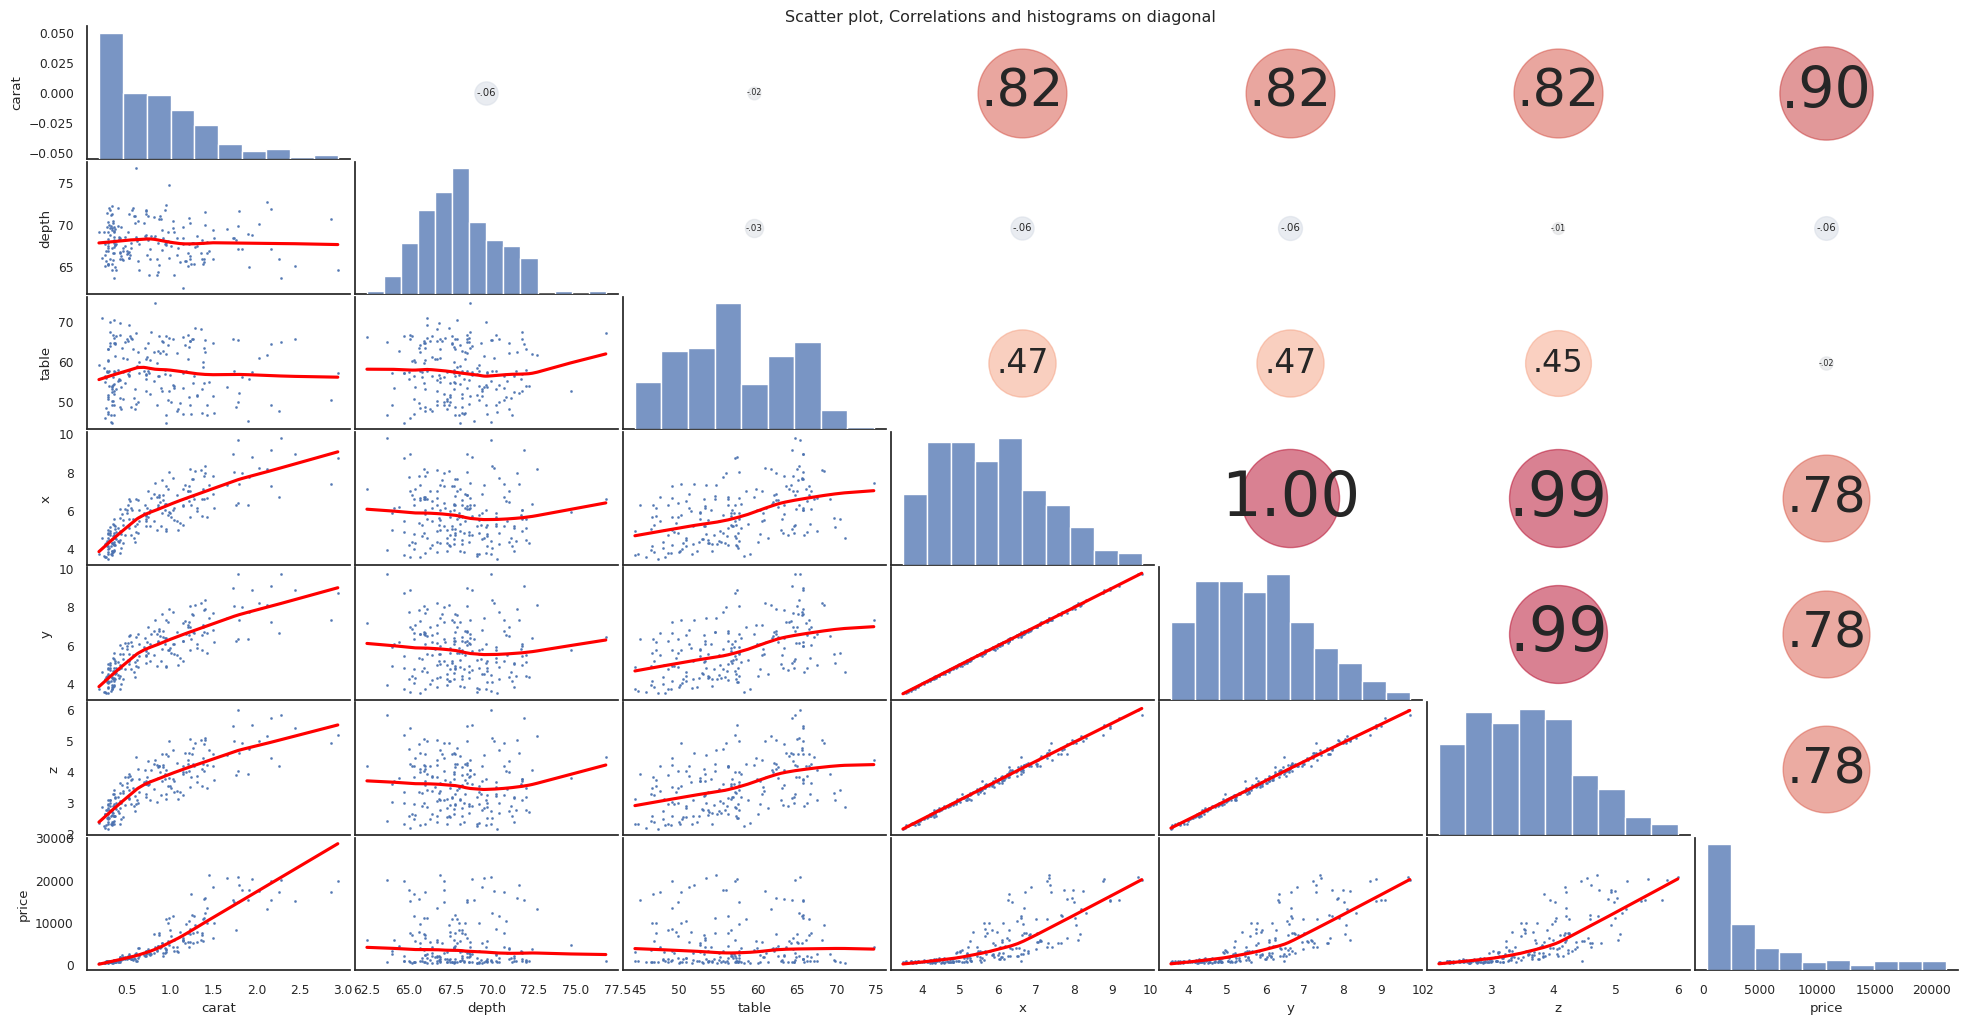

In [ ]:
def ScatterCorrHist(df):
  def corrdot(*args, **kwargs):
    # credit: https://stackoverflow.com/questions/48139899
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca();
    ax.set_axis_off();
    msz = abs(corr_r) * 5000   # marker size
    fsz = abs(corr_r) * 40 + 5 # font size
    ax.scatter([.5], [.5], msz, [corr_r], alpha=0.5, cmap='coolwarm', vmin=-1, vmax=1, transform=ax.transAxes)
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction", ha='center', va='center', fontsize=fsz)

  sns.set(style='white', font_scale=.8);
  g = sns.PairGrid(df, aspect=1, diag_sharey=False);
  g.fig.set_size_inches(20,10)
  g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color':'red'}, scatter_kws={'s':1});
  g.map_diag(sns.histplot, kde_kws={'color':'black'});
  g.map_upper(corrdot);
  g.fig.suptitle("Scatter plot, Correlations and histograms on diagonal", y=1);
  _ = plt.subplots_adjust(hspace=0.02, wspace=0.02);
  _ = plt.show();

ScatterCorrHist(tXY.head(200))  # takes a minute time to run

In [ ]:
tmr = Timer()

⏳ started. You have 60 sec. Good luck!


<hr color=green size=40>

<strong><font color=green size=5>⏳Timed Green Playground (TGP): Your ideas, code, documentation, and timer START HERE!</font></strong>

<font color=green>Students: Keep all your definitions, code, documentation in <b>TGP</b>. Modifying any code outside of TGP incurs penalties.

<font color=green><h3><b>$\alpha$. Build polynomial features</b><h3>

In [ ]:
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder
from sklearn.linear_model import LinearRegression

le = LabelEncoder() # Encodes the categorical type of data to numerical

# Transform the categorical data in training features to numerical
tX['cut'] = le.fit_transform(tX['cut'])
tX['color'] = le.fit_transform(tX['color'])
tX['clarity'] = le.fit_transform(tX['clarity'])

# Transform the categorical data in testing features to numerical
vX['cut'] = le.fit_transform(vX['cut'])
vX['color'] = le.fit_transform(vX['color'])
vX['clarity'] = le.fit_transform(vX['clarity'])

tX0 = tX.iloc[:20000,:]   # subsample for experimentation
tY0 = tY[:20000]   # subsample for experimentation

poly = PolynomialFeatures(degree=5)
tX0_in = poly.fit_transform(tX0.select_dtypes(include=np.number))
vX_in = poly.transform(vX.select_dtypes(include=np.number))

<font color=green><h3><b>$\beta$. Fit the model to the training dataset</b><h3>

In [ ]:
m = LinearRegression()
m.fit(tX0_in, tY0)

LinearRegression()

<font color=green><h3><b>$\gamma$. Generate and post-process predictions.</font>

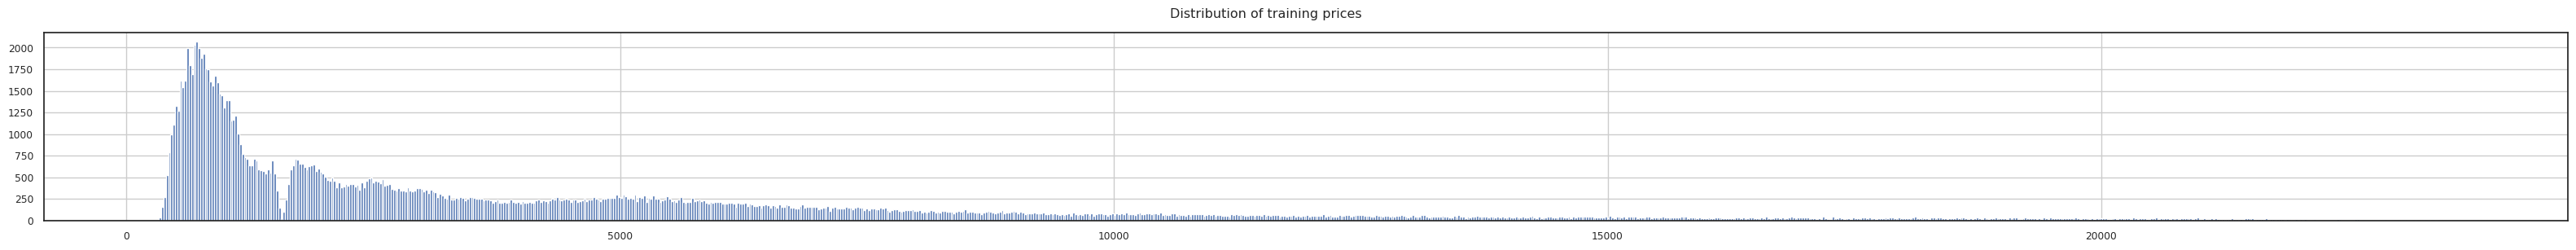

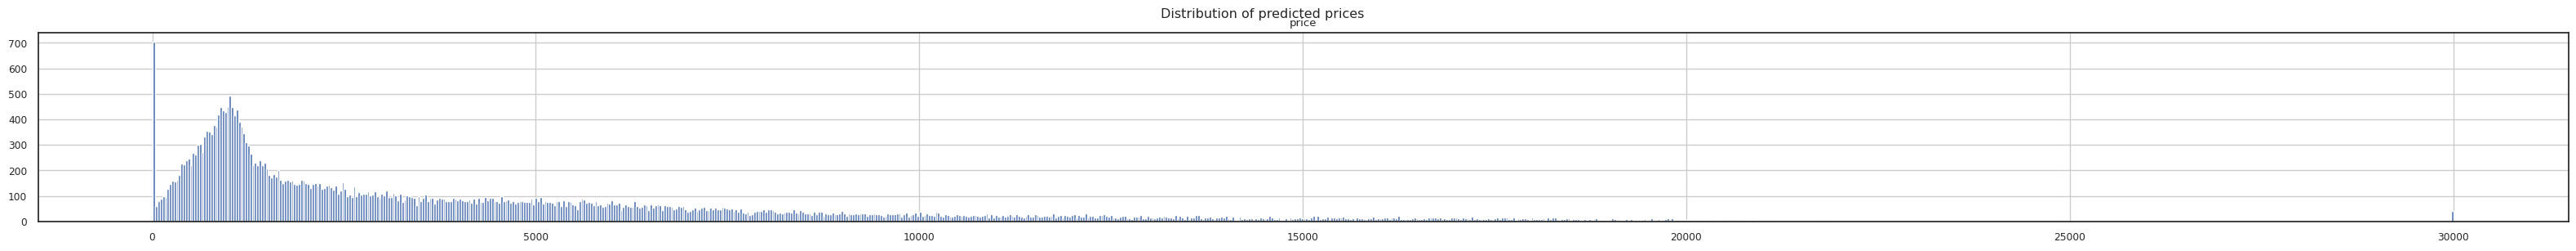

In [ ]:
pY = pd.DataFrame(m.predict(vX_in), index=range(1,len(vX)+1), columns=['price'])  # ensure that labels and observations are in corresponding order
pY = pY.clip(lower=10, upper = 30000)  # ensures no negative prices
_ = tY.hist(figsize=(40,3), bins=1000);  _ = plt.suptitle("Distribution of training prices");
_ = pY.hist(figsize=(40,3), bins=1000);  _ = plt.suptitle("Distribution of predicted prices");
ToCSV(pY, 'Nastya_version_0')

<font color=green><h3><b>$\epsilon$. Documentation</b></h3></font>

<font color=green><h4><b>Task 1. Explain Decisions in Preprocessing Pipeline</b></h4></font>

<font color=green>
Explain elements of your preprocessing pipeline i.e. feature engineering, subsampling, clustering, dimensionality reduction, etc.</font>

<font color=green>

1. Why did you choose these elements? (Something in EDA, prior experience,...? Note: EDA is not required)
1. How do you evaluate the effectiveness of these elements?
1. What else have you tried that worked or didn't?

</font>

<font color=red><b>Your answer here.</b></font>

1. We have decided to save all the features that were present in the dataset. However, it was needed to transform the categorical data in the "cut", "color" and "clarity" variables to the numerical type. It was done through the LabelEncoder() transformer.

2. The effectiveness of the elements was evaluated with the help of the scatter correlation histogram. Even though "table" and "depth" features didn't show much correlation with the target variable, they were decided to be kept for the sake of better predictions.

3. Several things were tried during the EDA process:
  * Combine "x", "y", "z" into one variable (~ "volume") (as "x", "y", "z" show high correlation with each other)
  * Delete "table" variable which is highly correlated with the dimensions but shows low relation to the target variable.

  Nevertheless, the performance of the model accounting previously mentioned points was lower. What helped is changeing of the "degree" of the "PolynomialFeatures" and setting the "upper" parameter of the "DataFrame".

<font color=green><h4><b>Task 2. Explain Decisions in Modeling Pipeline</b></h4></font>

<font color=green>
Explain your modeling approach, i.e. ideas you tried and why you thought they would be helpful.

1. How did these decisions guide you in modeling?
1. How do you evaluate the effectiveness of these elements?
1. What else have you tried that worked or didn't?

</font>

<font color=red><b>Your answer here.</b></font>

1. Due to lower results of tuning other hyperparameters ("x", "y", "z", "table") the model was tuned in accordance to the task complexity. As we have at least 3 dimensions, the "degree" of the "PolynomialFeatures" was decided to be increased. And the "upper" parameter in the "DataFrame" helps to lower the error from the outliers.

2. During the process of the competition several tactics were chosen for evaluating the performance of the model with different parameters (another notebook with different approach can be found by this link: https://colab.research.google.com/drive/16AwJV20W6i7ngOISd98WPr72Q70TXLiV?usp=sharing). Several tests were ran evaluating the performance of the model based on the testing samples which were received from slicing the dataset with known "price" values into training and testing.

3. Another great approach is to use the Ridge regression model. This estimator has built-in support for multi-variate regression. Moreover, removing outliers by analyzing the scatter plots was tried. However, due to the complications in the realization it was decided not to do so.

<font color=green><h3><b>$\zeta$. References</b></h3></font>

<font color=red><b>Your answer here.</b></font>

<font color=green>
Cite your sources to help your peers learn from these (and to avoid plagiarism claims). At the least, HOML textbook should be cited. Use Google Scholar to draw APA citation format for books and publications. Also cite StackOverflow, package documentation, and other meaningful internet resources.

1. https://hastie.su.domains/ISLP/ISLP_website.pdf
1. https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model
1. https://pandas.pydata.org/docs/reference/index.html
1. https://stackoverflow.com/
1. https://towardsdatascience.com/predicting-diamond-prices-using-basic-measurement-metrics-bc8ba821c8f6

<font size=5>⌛</font> <strong><font color=green size=5>Do not exceed competition's runtime limit! Do not write code outside TGP</font></strong>
<hr color=green size=40>

In [ ]:
tmr.ShowTime()    # measure Colab's runtime. Do not remove. Keep as the last cell in your notebook.

Runtime is 26 sec


## 💡**Starter Ideas**

1. Tune model hyperparameters
1. Try to linear and non-linear feature normalization: shift/scale, log, divide features by features (investigate scatterplot matrix)
1. Try higher order feature interactions ($x_i^a$, $x_ix_j$, ...) to identify new key features or their linear combinations. With too many features you can use a smaller subsample or reduce dimensionality of feature space using [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html), [tSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html), or [UMAP](https://umap-learn.readthedocs.io/en/latest/).
1. Do a thorough EDA and understand non-linear relation in I/O. Are any interactions more special than others (E.g. is diamond *volume* a better predictor?)
1. If you note a shift in trend for any predictors, try building a model for each trend.
1. Evaluate predictions and focus on poorly predicted "groups". Can they be identified and modeled separately?
1. Do scatter plots show piecewise linear shape? Can a separate linear model be used on each support of approximately linear X-Y relation?
1. How are categorical features treated by the SKLearn models? Is there a [better way](https://www.google.com/search?q=ways+to+encode+categorical+data) to encode these (perhaps, ordinal) features?
  1. E.g. you could replace codes (or groups of codes) with their frequencies, which may capture the implied "distance" or rarity between category levels.
  1. If encoding ordinal features with integers, should non-equidistant values be considered?
1. Learn about [modeling price of a diamond](https://www.google.com/search?q=machine+learning+model+price+diamond).
1. Try post-processing: shifting/scaling/transforming the distribution of predicted prices `pY` to match the distribution of training prices `tY`
